In [42]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [43]:
MAX_FLOAT_SIZE = 2e32-1

## Objectif

Dans ce projet on souhaite mettre en oeuvre une méthode pour estimer les paramètres d’une fonction
linéaire. Pour cela on on suppose avoir accès à des observations bruitées de cette fonction. En introduisant un modèle de bruit Gaussien, on étudie les propriétés de cet estimateur. Notamment, on montre
la convergence (dans un sens que l’on précisera) de cet estimateur.

## Préliminaires

Soit $\beta_0$ , $\beta_1$ $\in \mathbb{R}$. On considère une fonction $Y: [0,1] \rightarrow{} \mathbb{R}$ telle que pour tout $x \in [0,1]$,

$$
    Y(x) = \beta_0 + \beta_1 x
$$

On suppose que $\beta_0, \ \beta_1$ sont des paramètres inconnus que l’ont souhaite estimer à partir d’observation
de la fonction $Y$ en $n$ points distincts $(x_1, \ \dots, \ x_n)$, avec $n \in \mathbb{N}$. On supposera que l’on observe la
fonction $Y$ en ces points mais que ces observation sont bruitées. En particulier le practicien observe
des réalisations de

$$
    Y_{obs}(x_i) = Y(x_i) + \epsilon_i , i \in \{1, \ \dots, \ n\},
$$

où  $(\epsilon_i)_{i \in \mathrm{N}}$ est une suite de variable aléatoire $i.i.d.$ suivant la loi normale centrée de variance $\sigma^2$ avec $\sigma >0$.

## Résolution du problème des moindres carrés

**S1.** Proposer et implémenter un algorithme de simulation de $Y_{obs}^{n} := (Y_{obs}(x_1), \dots, Y_{obs}(x_n))$ lorsque les $(x_1, \dots, x_n)$ sont choisis de façon uniforme sur $[0,1]$.

In [73]:
class LinearRegressionSimulator:
    def __init__(
            self, 
            beta: np.ndarray, 
            sigma: float,
        ) -> None:
        self.__beta = beta

        if (sigma < 0):
            raise AttributeError("sigma must be non negative")
        self.__sigma = sigma
        
    def simulate(
            self,
            n_obs : int
        ):
        epsilon : np.ndarray = np.\
            random\
            .normal(0, self.__sigma, n_obs)
        
        x = np.array([k for k in np.linspace(0, 1, num= n_obs)])
                
        x = np.insert(
            x.reshape((n_obs, 1)),
            0,
            1,
            axis = 1
        )
        
        return x @ self.__beta + epsilon
    
    @staticmethod
    def get_x(n_obs : int):
        return np.array([k for k in np.linspace(0, 1, num= n_obs)])
         
    def get_y(self, n_obs: int):
        x = self.get_x(n_obs)

        x = np.insert(
            x.reshape((n_obs, 1)),
            0,
            1,
            axis = 1
        )

        return x @ self.__beta



In [92]:
# these values are arbitrary
beta = np.array([1,2])
sigma = 0.1
n_obs = 20

In [93]:
lin_reg_simulator = LinearRegressionSimulator(
    beta,
    sigma
)

In [94]:
x = lin_reg_simulator.get_x(n_obs)
y_obs = lin_reg_simulator.simulate(n_obs)

In [95]:
x

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [96]:
y_obs

array([1.05947629, 0.90301448, 1.33594449, 1.27705248, 1.39692305,
       1.66902668, 1.58099528, 1.60078378, 1.97269828, 1.9794493 ,
       1.78597903, 2.33780431, 2.24418804, 2.51842697, 2.57875988,
       2.61332481, 2.55436954, 2.63528719, 2.92280465, 3.05897938])

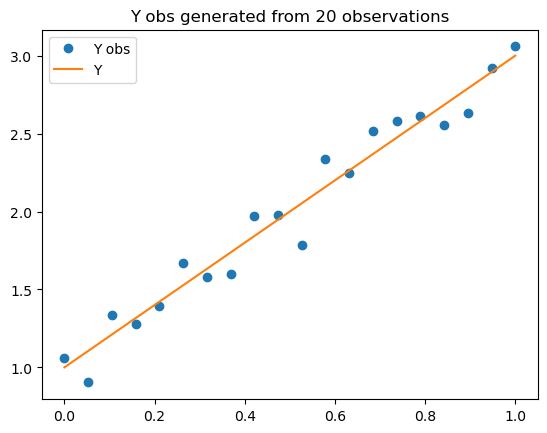

In [99]:
plt.plot(
    x, 
    y_obs, 
    'o',
    label = "Y obs"
)
plt.plot(
    x, 
    lin_reg_simulator.get_y(n_obs),
    label="Y"
)
plt.title(f"Y obs generated from {n_obs} observations")
plt.legend()

**T1.** Écrire le problème sous la forme

$$
    Y^n = X^n \beta
$$

où $Y^n = (Y(x_1), \dots, Y(x_n))^T \in \mathbb{R^n}$. On précisera $X^n$ et $\beta$.

Comme on a déjà fait dans l'exercice **S1**, il suffit de prendre : 

$$
    X^n = 
        \begin{pmatrix}
            1 & x_1\\
            1 & x_2 \\
            \vdots & \vdots \\
            1 & x_n
        \end{pmatrix}, \

    \beta = \
        \begin{pmatrix}
            \beta_0 \\
            \beta_1
        \end{pmatrix}
$$

On admet maintenant que $(X^n)^T$ est inversible où $(X^n)^T$ est la transposé de la matrice $(X^n)$. On s'intéresse à l'estimateur des moindres carrés de $\beta$ que l'on note $\hat{\beta}^n$ et qui est défini par 

$$
    \hat{\beta^n} := \underset{\beta \in \mathbb{R^2}}{\operatorname{arg \ min}} || Y_{obs}^n - X^n \beta || ^2
$$

où $||.||$ est la norme euclidienne dans $\mathbb{R}^n$. On peut montrer que cette solution maximise la densité de $Y_{obs}^n$.

**T2.** Montrer que $\hat{\beta}^n = ((X^n)^T X^n)^{-1}(X^n)^T Y_{obs}^n$ 

On va écrire l'erreur quadratique et, pour simplifier, on va employer la notation $X^n = X$ et $Y_{obs}^n = Y_{obs}$:

$$
    \begin{aligned}
    E(\beta) & = || (Y_{obs}- X\beta) ||^2 \\
             & = (Y_{obs}- X \beta)^T(Y_{obs} - X \beta) \\
             & = Y_{obs}^T Y_{obs} - 2 Y_{obs}^T X \beta + \beta ^T X ^T X \beta
    \end{aligned}
$$

Il faut que $\frac{d E(\beta)}{d \beta} = 0$. Alors, on a:

$$
    2 \beta^T X^T X - 2 Y_{obs}^T X = 0 \\

    \beta ^T X^T X = Y_{obs}^T X \\

    X^T X \beta = X^T Y_{obs}
$$

Donc on trouve le résultat:

$$
    \hat{\beta}^n = (X^T X)^{-1} X^T Y_{obs}
$$

**T3** Quelle est la loi de $\hat{\beta}^n$? En déduire que $\mathbb{E}[\hat{\beta^n}] = \beta$. On dit que l'estimateur $\hat{\beta}^n$ est non biaisé.

En sachant que les $(\varepsilon_i)_{i \leq n}$ sont *i.i.d*, le vecteur d'erreurs $\varepsilon = (\varepsilon_i)_{i \leq n}$ une loi normale de moyenne $0_{n}$ et matrice de covariance $\sigma^2 I_{n}$

$$
    \varepsilon \sim \mathcal{N}(0_{n}, \ \sigma^2 I_{n})  \\

    Y_{obs} = X \beta + \varepsilon \Rightarrow 

    Y_{obs} \sim \mathcal{N}(X \beta, \sigma^2 I_{n})
$$

Alors:

$$
    \hat{\beta} = (X^T X)^{-1} X^T Y_{obs} \Rightarrow \hat{\beta} \sim \mathcal{N} (A X\beta, \sigma^2 A A^T)
$$

où $A = (X^T X)^{-1} X^T$. On sait que 
$$
\begin{aligned}
    AX & = (X^T X)^{-1} X^T X \\
       & = I_{n}
\end{aligned}
$$

et 

$$
\begin{aligned}
    A A^T & = (X^T X)^{-1}X^T X (X^T X)^{-1} \\
          & = (X^T X)^{-1}
\end{aligned}
$$

Alors, on conclut que $ \hat{\beta} \sim \mathcal{N} (\beta, \sigma^2 (X^T X)^{-1}) $